In [2]:
!pip install split-folders

  Using cached split_folders-0.5.1-py3-none-any.whl (8.4 kB)


In [4]:
import os
import torchvision
import torch
import time
import splitfolders
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [5]:
data_dir = '../input/all-brain-datset/all_dataset'
batch_size=32
image_size=224

In [6]:
splitfolders.ratio(data_dir+ "/Training", output='brain-tumor-classification-mri', ratio=(0.8,0.1,0.1))

Copying files: 3264 files [00:09, 332.43 files/s]


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
image_size = (224,224)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
])


dataset_training = ImageFolder( "./brain-tumor-classification-mri/train", transform=transform)
dataset_validating = ImageFolder( "./brain-tumor-classification-mri/val", transform=transform)
dataset_testing = ImageFolder( "./brain-tumor-classification-mri/test", transform=transform)

print(f'Size train {len(dataset_training)}') 
print(f'Size valid {len(dataset_validating)}')
print(f'Size train {len(dataset_testing)}')

Size train 2609
Size valid 325
Size train 330


In [11]:
batch_size=32
train_loader = DataLoader(dataset_training,batch_size=batch_size,shuffle=True)
val_loader =  DataLoader(dataset_validating,batch_size=batch_size,shuffle=False)
test_loader = DataLoader(dataset_testing,batch_size=batch_size,shuffle=False)

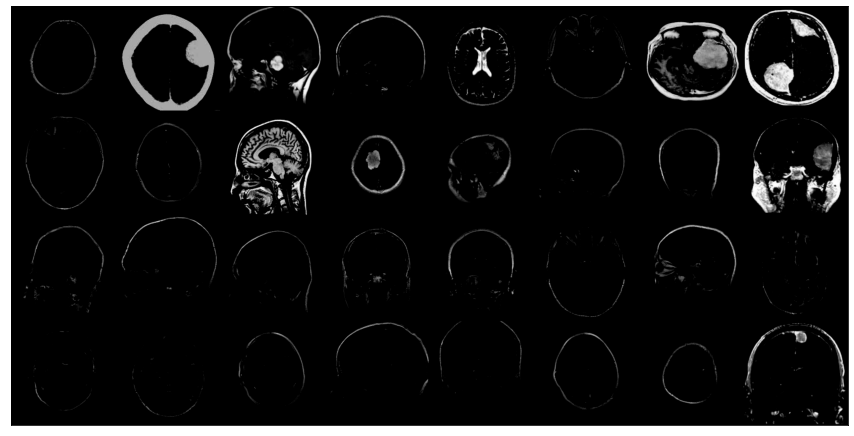

In [12]:
examples = iter(train_loader)
img,labels = examples.next()
def show_batch(dataset_loader):
    _, ax = plt.subplots(figsize=(15, 15))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(img).permute(1, 2, 0))
show_batch(train_loader)

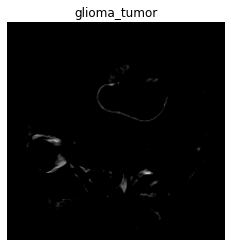

In [13]:
def show_image(img, label):
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f'{dataset_training.classes[label]}')
    plt.axis("off")
    plt.show()

show_image(*dataset_training[11])

In [14]:
def training_step(model, batch):
    images, labels = batch
    if torch.cuda.is_available():
        images=images.to(device)
        labels=labels.to(device)
    out = model(images)  
    loss = F.cross_entropy(out, labels)  
    acc = accuracy(out, labels) 
    return {'train_loss': loss,'train_acc':acc}

def validation_step(model, batch):
    images, labels = batch
    if torch.cuda.is_available():
        images=images.to(device)
        labels=labels.to(device)
    out = model(images)  
    loss = F.cross_entropy(out, labels)  
    acc = accuracy(out, labels)  
    return {'val_loss': loss.detach(), 'val_acc': acc}

def validation_epoch_end(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() 
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()  
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def epoch_end(epoch, result):
    print("Epoch [{}], time(s): {:.4f}, train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['epoch_time'], result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

def test_step(model, batch):
    images, labels = batch
    if torch.cuda.is_available():
        images=images.to(device)
        labels=labels.to(device)
    out = model(images)  
    acc = accuracy(out, labels) 
    return {'y_test': labels, 'prediction': out}

def test_end(outputs, name):
    y_test = [y.item() for x in outputs for y in x['y_test'] ]
    y_prediction = [torch.argmax(y).item() for x in outputs for y in x['prediction']]
    
    report = classification_report(y_test, y_prediction, target_names=dataset_training.classes)
    print(f'Test {name} Pytorch')
    print(f'{report}')
    
    fig, ax = plt.subplots(figsize=(10, 10)) 
    ax.set_title(f'Confusion Matrix {name} Pytorch')
    cm = confusion_matrix(y_test,y_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dataset_training.classes)
    disp.plot(cmap='Blues', ax=ax)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [15]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model, batch) for batch in val_loader]
    return validation_epoch_end(outputs)

@torch.no_grad()
def test(model, test_loader, name):
    model.eval()
    outputs = [test_step(model, batch) for batch in test_loader]
    return test_end(outputs, name)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        t0 = time.time()
        model.train()
        train_losses = []
        train_accuracy = []
        for batch in train_loader:
            optimizer.zero_grad()
            outputs = training_step(model, batch)
            train_losses.append(outputs['train_loss'])
            train_accuracy.append(outputs['train_acc'])
            outputs['train_loss'].backward()
            optimizer.step()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracy).mean().item()
        result['epoch_time'] = time.time() - t0
        epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
def display_plot(history, name):
    acc = [epoch["train_acc"] for epoch in history]
    val_acc = [epoch["val_acc"] for epoch in history]

    loss = [epoch['train_loss'] for epoch in history]
    val_loss = [epoch['val_loss'] for epoch in history]

    plt.figure(figsize=(14, 8))
    tab_plot = [{
                "id": 1,
                "variables":[acc, val_acc],
                "labels":['Training Accuracy', 'Validation Accuracy'],
                "legend":'lower right',
                "title":f'Accuracy Pytorch - {name}',
                "ylabel":'Accuracy'
            },{ 
                "id": 2,
                "variables":[loss, val_loss],
                "labels":['Training Loss', 'Validation Loss'],
                "legend":'upper right',
                "title":f'Loss Pytorch - {name}',
                "ylabel":'Loss'
            }]
    

    epochs_range = range(25)
    for tab in tab_plot: 
        plt.subplot(1, 2, tab['id'])
        plt.plot(epochs_range,  tab['variables'][0], label=tab['labels'][0], marker='o', markerfacecolor='green',color='green')
        plt.plot(epochs_range , tab['variables'][1], label=tab['labels'][1], marker='o', markerfacecolor='blue',color='blue')
        plt.legend(loc=tab['legend'])
        plt.title(tab['title'])
        plt.xlabel('Epochs')
        plt.ylabel(tab['ylabel'])
    plt.show()

In [17]:
model_mobilenet_v2 = models.mobilenet_v2(num_classes=4, pretrained=False)
model_mobilenet_v2.to(device)
model_mobilenet_v2.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [21]:
opt_func = torch.optim.Adam
lr = 0.001
print('Train Mobilenetv2 Pytorch')
history_mobilenet_v2= fit(25, lr, model_mobilenet_v2, train_loader, val_loader, opt_func)

Train Mobilenetv2 Pytorch
Epoch [0], time(s): 23.8933, train_loss: 1.0686, train_acc: 0.5555, val_loss: 1.6731, val_acc: 0.3920
Epoch [1], time(s): 22.9429, train_loss: 0.7937, train_acc: 0.6721, val_loss: 0.8097, val_acc: 0.6506
Epoch [2], time(s): 23.4639, train_loss: 0.6339, train_acc: 0.7520, val_loss: 0.9044, val_acc: 0.6108
Epoch [3], time(s): 23.3522, train_loss: 0.5013, train_acc: 0.8047, val_loss: 0.7602, val_acc: 0.7244
Epoch [4], time(s): 23.2633, train_loss: 0.4238, train_acc: 0.8383, val_loss: 0.6005, val_acc: 0.7983
Epoch [5], time(s): 23.2580, train_loss: 0.3514, train_acc: 0.8724, val_loss: 0.6128, val_acc: 0.7812
Epoch [6], time(s): 23.2388, train_loss: 0.2835, train_acc: 0.8999, val_loss: 0.6166, val_acc: 0.7818
Epoch [7], time(s): 22.8587, train_loss: 0.2491, train_acc: 0.9091, val_loss: 0.7359, val_acc: 0.7403
Epoch [8], time(s): 23.7163, train_loss: 0.2509, train_acc: 0.9132, val_loss: 1.0079, val_acc: 0.6960
Epoch [9], time(s): 23.3308, train_loss: 0.1845, train_a

Test Mobilenetv2 Pytorch
                  precision    recall  f1-score   support

    glioma_tumor       0.90      0.83      0.86        94
meningioma_tumor       0.88      0.88      0.88        95
        no_tumor       0.86      0.98      0.92        50
 pituitary_tumor       0.94      0.93      0.94        91

        accuracy                           0.90       330
       macro avg       0.89      0.91      0.90       330
    weighted avg       0.90      0.90      0.90       330



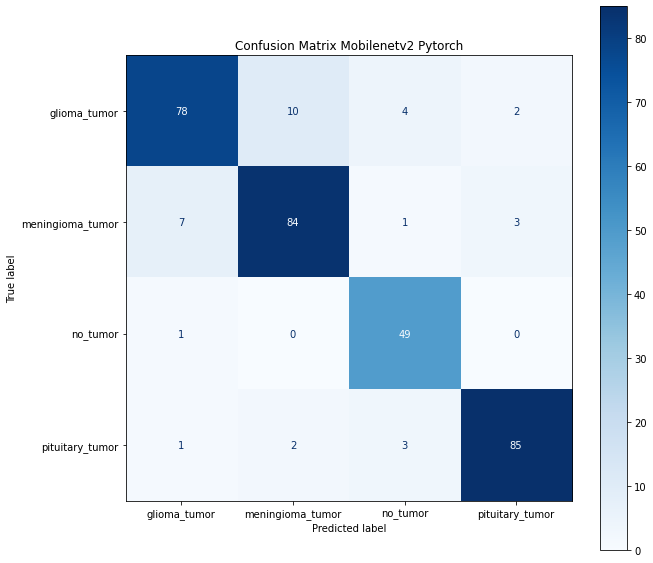

In [24]:
test(model_mobilenet_v2,test_loader, 'Mobilenetv2')

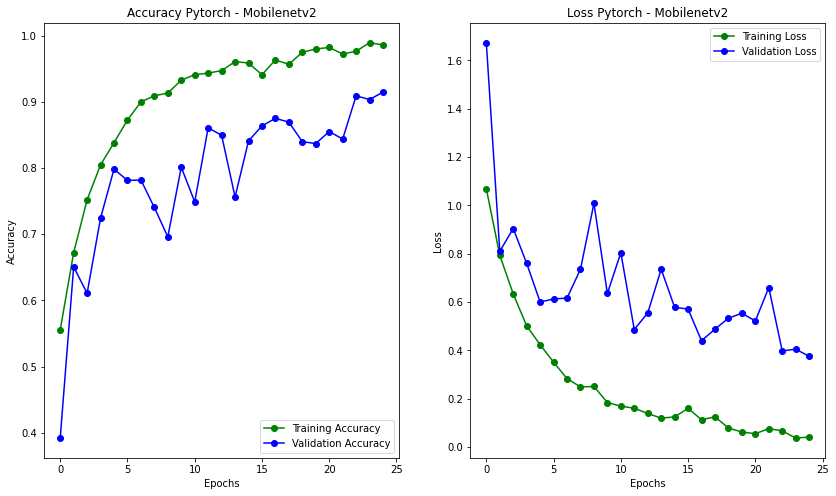

In [25]:
display_plot(history_mobilenet_v2, 'Mobilenetv2')

In [48]:
model_densenet121 = models.densenet121(num_classes=4, pretrained=False)
model_densenet121.to(device)
model_densenet121.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [49]:
print('Train DenseNet121 Pytorch')
history_densenet121 = fit(25, lr, model_densenet121, train_loader, val_loader, opt_func)

Train DenseNet121 Pytorch
Epoch [0], time(s): 33.1059, train_loss: 0.9486, train_acc: 0.6005, val_loss: 1.0833, val_acc: 0.6222
Epoch [1], time(s): 33.0827, train_loss: 0.7563, train_acc: 0.6987, val_loss: 1.2326, val_acc: 0.5716
Epoch [2], time(s): 33.1913, train_loss: 0.6581, train_acc: 0.7446, val_loss: 0.8337, val_acc: 0.6227
Epoch [3], time(s): 33.3194, train_loss: 0.5520, train_acc: 0.7883, val_loss: 0.9494, val_acc: 0.6222
Epoch [4], time(s): 33.1802, train_loss: 0.4700, train_acc: 0.8278, val_loss: 2.0555, val_acc: 0.4812
Epoch [5], time(s): 33.1176, train_loss: 0.4285, train_acc: 0.8302, val_loss: 0.9235, val_acc: 0.6562
Epoch [6], time(s): 33.0165, train_loss: 0.4003, train_acc: 0.8484, val_loss: 1.8246, val_acc: 0.5625
Epoch [7], time(s): 33.1951, train_loss: 0.3600, train_acc: 0.8747, val_loss: 0.5146, val_acc: 0.7926
Epoch [8], time(s): 33.2053, train_loss: 0.3110, train_acc: 0.8922, val_loss: 0.2972, val_acc: 0.9006
Epoch [9], time(s): 33.1684, train_loss: 0.2805, train_a

Test DenseNet121 Pytorch
                  precision    recall  f1-score   support

    glioma_tumor       0.77      0.95      0.85        94
meningioma_tumor       1.00      0.76      0.86        95
        no_tumor       0.87      0.94      0.90        50
 pituitary_tumor       0.98      0.95      0.96        91

        accuracy                           0.89       330
       macro avg       0.90      0.90      0.89       330
    weighted avg       0.91      0.89      0.89       330



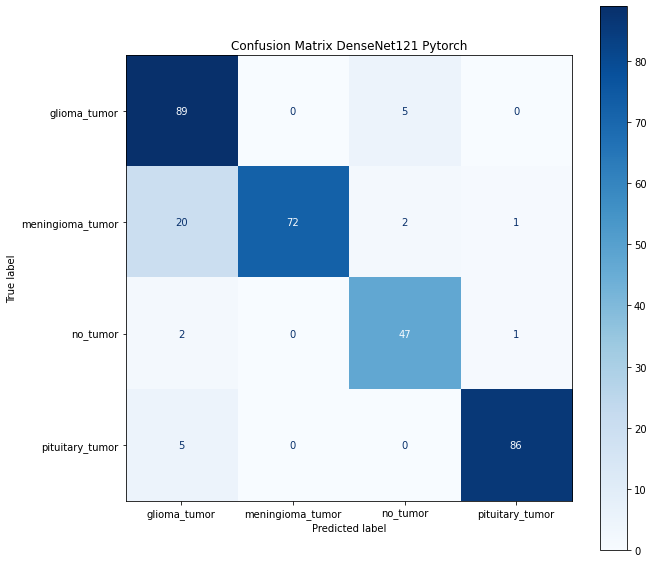

In [50]:
test(model_densenet121,test_loader, 'DenseNet121')

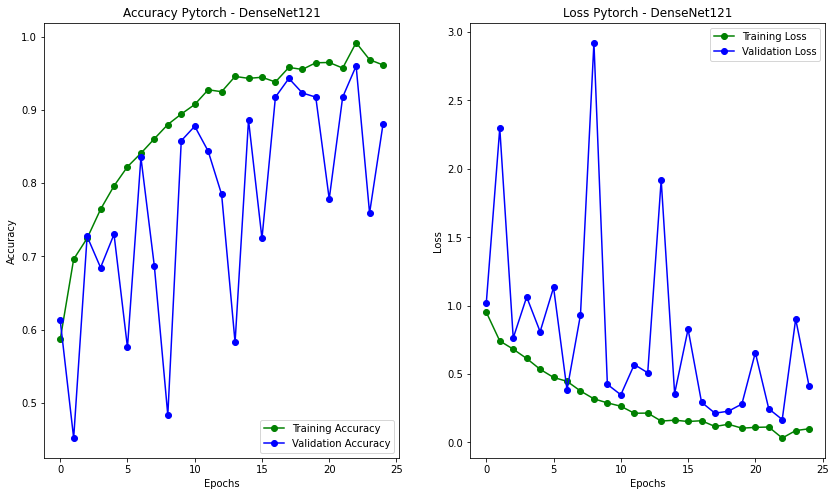

In [47]:
display_plot(history_densenet121, 'DenseNet121')

In [36]:
model_resnet50 = models.resnet50(num_classes=4, pretrained=False)
model_resnet50.to(device)
model_resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [37]:
print('Train Resnet50 Pytorch')
history_resnet50 = fit(25, lr, model_resnet50, train_loader, val_loader, opt_func)

Train Resnet50 Pytorch
Epoch [0], time(s): 30.1890, train_loss: 1.1672, train_acc: 0.5529, val_loss: 1.5330, val_acc: 0.6153
Epoch [1], time(s): 30.2369, train_loss: 0.8535, train_acc: 0.6690, val_loss: 0.9702, val_acc: 0.6790
Epoch [2], time(s): 30.4505, train_loss: 0.7321, train_acc: 0.7122, val_loss: 2.1946, val_acc: 0.5824
Epoch [3], time(s): 30.1711, train_loss: 0.6660, train_acc: 0.7398, val_loss: 2.9118, val_acc: 0.4460
Epoch [4], time(s): 30.2495, train_loss: 0.6144, train_acc: 0.7657, val_loss: 0.8642, val_acc: 0.6920
Epoch [5], time(s): 30.2667, train_loss: 0.4608, train_acc: 0.8336, val_loss: 1.1138, val_acc: 0.5722
Epoch [6], time(s): 30.1968, train_loss: 0.4265, train_acc: 0.8420, val_loss: 0.7336, val_acc: 0.7358
Epoch [7], time(s): 30.1189, train_loss: 0.3709, train_acc: 0.8611, val_loss: 0.8248, val_acc: 0.7500
Epoch [8], time(s): 30.2643, train_loss: 0.3422, train_acc: 0.8747, val_loss: 0.5035, val_acc: 0.8210
Epoch [9], time(s): 30.2732, train_loss: 0.3145, train_acc:

Test Resnet50 Pytorch
                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.86      0.91        94
meningioma_tumor       0.91      0.94      0.92        95
        no_tumor       0.88      0.90      0.89        50
 pituitary_tumor       0.92      0.97      0.94        91

        accuracy                           0.92       330
       macro avg       0.92      0.92      0.91       330
    weighted avg       0.92      0.92      0.92       330



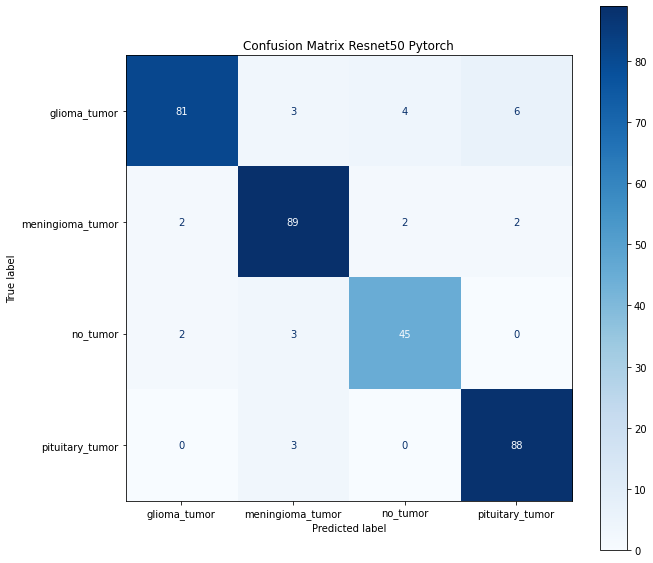

In [39]:
test(model_resnet50,test_loader, 'Resnet50')

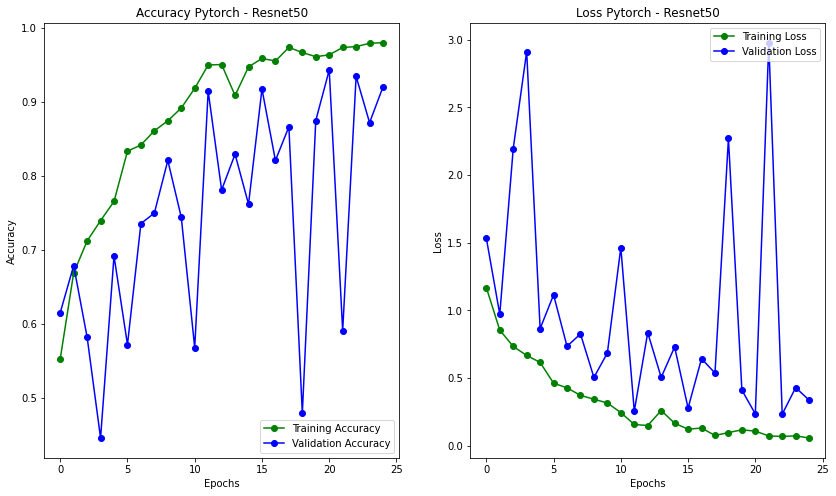

In [40]:
display_plot(history_resnet50, 'Resnet50')